### Tuning dos Parâmetros

Resultados dos modelos relevantes para a base de dados census:

Árvore de decisão - 81.04% <br>
Random Forest - 85.02% <br>
kNN - 83.11% <br>
Regressão logística - 84.95% <br>
SVM - 85.08% <br>
MLP - 80.63%

Tanto o Aprendizado por Regras quanto o Naive Bayes não estão inclusos por não possuirem parâmetros para otimizar.

### Preparação dos dados

In [1]:
import pickle

with open(r'../_Material/Bases de dados/Bases pre-processadas/base_census.pkl', mode = 'rb') as arquivo:
    x_previsores, y_classes, x_teste, y_teste = pickle.load( arquivo )

In [2]:
x_previsores.shape, y_classes.shape

((27676, 108), (27676,))

In [3]:
x_teste.shape, y_teste.shape

((4885, 108), (4885,))

In [4]:
import numpy as np

# Juntando os dados de teste e treinamento
x_census = np.concatenate(( x_previsores, x_teste ), axis = 0 )
y_census = np.concatenate(( y_classes, y_teste ), axis = 0 )

# Como se trata de um código para estudos e não de um caso real, a base de dados foi limitada a 2.000 registros
# A execução do algoritmo com a base de dados inteira pode levar muito tempo - Talvez mais da metade de um dia
x_census = x_census[:2000]
y_census = y_census[:2000]

# Verificando as dimensões
x_census.shape, y_census.shape

((2000, 108), (2000,))

In [5]:
# Classe para otimizar os modelos
from sklearn.model_selection import GridSearchCV

# Importando os classificadores relevantes
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier

In [6]:
# Armazenando os objetos para iteração
tupla_de_classificadores = (
    DecisionTreeClassifier,
    RandomForestClassifier,
    KNeighborsClassifier,
    LogisticRegression,
    SVC,
    MLPClassifier
)

# Armazenando conjunto de parâmetros para cada classificador
conjunto_de_parametros = {
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },

    'RandomForestClassifier': {
        'criterion': ['gini', 'entropy'],
        'n_estimators': [10, 20, 50, 100, 150],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },

    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 10, 20],
        'p': [1, 2],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },

    'LogisticRegression': {
        'tol': [0.0001, 0.00001, 0.000001],
        'C': [1.0, 1.5, 2.0],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },

    'SVC': {
        'tol': [0.0001, 0.00001, 0.000001],
        'C': [1.0, 1.5, 2.0],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    },

    'MLPClassifier': {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'batch_size': [10, 56]
    }
}


In [7]:
import warnings
from json import dumps  # Classe para exibir resultado formatado
from sklearn.exceptions import ConvergenceWarning

# Define a ação desejada para os avisos de convergência
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)


for classificador in tupla_de_classificadores:  # Para cada classificador na tupla de classificadores
    
    # Verificando qual a melhor configuração de parâmetros para o classificador
    grid_search = GridSearchCV(
        estimator = classificador(),
        param_grid = conjunto_de_parametros[classificador.__name__]
    )

    # Ajustando GridSearchCV
    grid_search.fit(x_census, y_census)

    # Substituindo conjunto de parâmetros pelo resultado
    conjunto_de_parametros[classificador.__name__] = {
        'Configuracao otimizada': grid_search.best_params_,
        'Resultado': f'{grid_search.best_score_*100:.2f}%'
    }

    # Print com DUMPS para deixar o resultado legível
    print(classificador.__name__, '\n', dumps(conjunto_de_parametros[classificador.__name__], indent=4), '\n')


DecisionTreeClassifier 
 {
    "Configuracao otimizada": {
        "criterion": "entropy",
        "min_samples_leaf": 5,
        "min_samples_split": 5,
        "splitter": "best"
    },
    "Resultado": "82.70%"
} 

RandomForestClassifier 
 {
    "Configuracao otimizada": {
        "criterion": "entropy",
        "min_samples_leaf": 5,
        "min_samples_split": 2,
        "n_estimators": 100
    },
    "Resultado": "85.30%"
} 

KNeighborsClassifier 
 {
    "Configuracao otimizada": {
        "metric": "minkowski",
        "n_neighbors": 20,
        "p": 2
    },
    "Resultado": "82.30%"
} 

LogisticRegression 
 {
    "Configuracao otimizada": {
        "C": 1.0,
        "solver": "saga",
        "tol": 0.0001
    },
    "Resultado": "84.70%"
} 

SVC 
 {
    "Configuracao otimizada": {
        "C": 1.0,
        "kernel": "sigmoid",
        "tol": 0.0001
    },
    "Resultado": "84.05%"
} 

MLPClassifier 
 {
    "Configuracao otimizada": {
        "activation": "identity",
        

### Validação Cruzada

Aplicando os parâmetros retornados pelo GridSearch para realizar a validação cruzada.

Detalhes:
10 testes (KFold=10) serão realizados 30 vezes, totalizando 300 testes com cada método de aprendizado de máquina. Esse número é bem aceito em artigos científicos para análise de métodos de aprendizado.

In [8]:
from sklearn.model_selection import cross_val_score, KFold

resultados = {}

print('Processando...', end=' ')

for index, classificador in enumerate(tupla_de_classificadores):  # Para cada classificador na tupla de classificadores

    # Desempacotando o dicionário com a configuração otimizada para o modelo do contexto
    configuracao_do_modelo = classificador(**conjunto_de_parametros[classificador.__name__]['Configuracao otimizada'])

    resultados[classificador.__name__] = []  # Criando chave com lista vazia

    for i in range(30):  # Testando o modelo com validação cruzada 30 vezes
        
        # Configurando para que a base de teste seja separada em 10 partes, e que cada parte seja separada aleatoriamente
        K = KFold(n_splits = 10, shuffle = True, random_state = i)

        # Validação cruzada
        score_validacao_cruzada = cross_val_score(
            estimator = configuracao_do_modelo,
            X = x_census,  # Base de dados
            y = y_census,  # Base de dados
            cv = K  # Quantidade de separações
        )
        
        # Adicionando resultado à lista (média dos 10 testes por loop)
        resultados[classificador.__name__].append(score_validacao_cruzada.mean())

    # Imprimindo o progresso do processamento
    print(f'{(index+1)/len(tupla_de_classificadores)*100:.2f}%', end=' .. ')

Processando... 16.67% .. 33.33% .. 50.00% .. 66.67% .. 83.33% .. 100.00% .. 

In [9]:
import pandas as pd

df = pd.DataFrame(resultados)
df.describe()

C:\Users\guilh\AppData\Local\Temp\ipykernel_11024\3849595749.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,SVC,MLPClassifier
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.815133,0.846167,0.825233,0.840200,0.835717,0.839700
std,0.005903,0.002644,0.002128,0.002648,0.002605,0.002011
min,0.806500,0.842000,0.821500,0.836500,0.831500,0.835500
25%,0.811125,0.844500,0.824000,0.837750,0.834500,0.838500
50%,0.813750,0.846000,0.825000,0.840500,0.835750,0.840250
75%,0.818875,0.846875,0.826500,0.841000,0.838000,0.841000
max,0.828000,0.852500,0.829500,0.847000,0.841000,0.843000


### Teste Shapiro

O teste de shapiro tem como hipótese nula que os dados seguem distribuição normal. Para este caso, o teste tem uma margem de erro de 5% e 95% de confiabilidade.

Verificação do tipo de distribuição dos dados



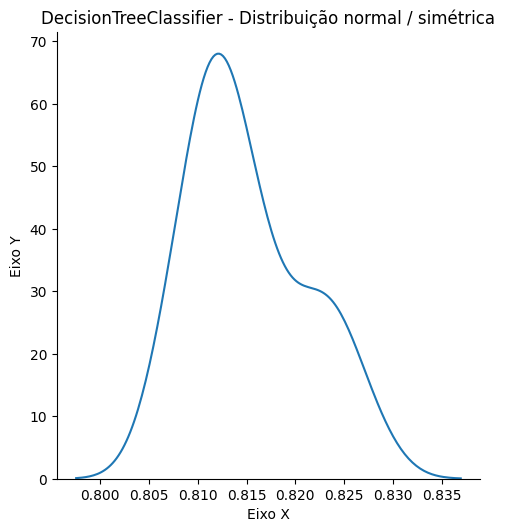

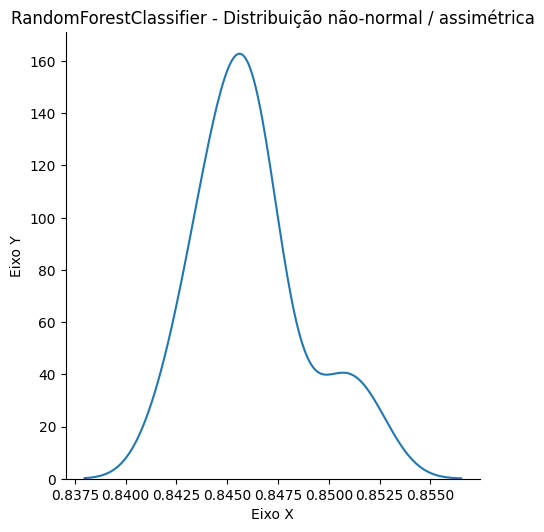

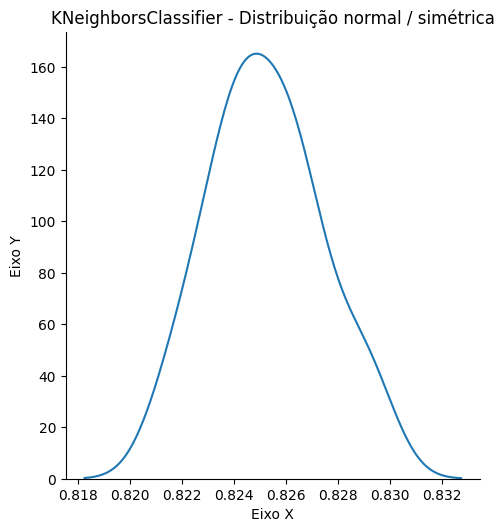

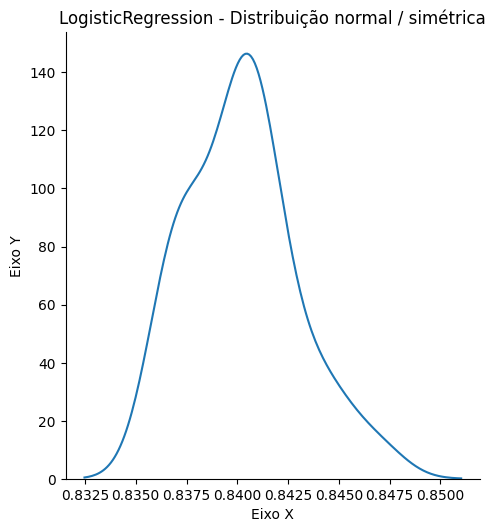

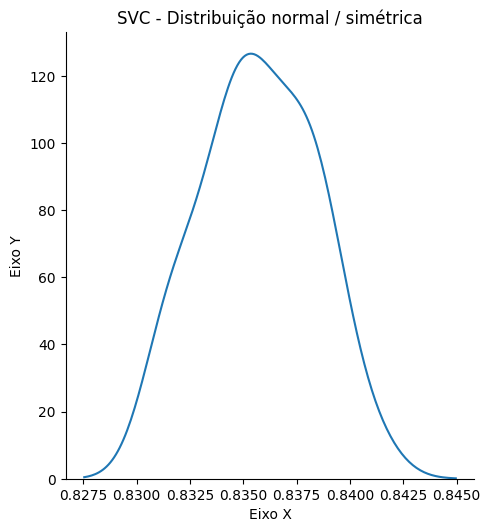

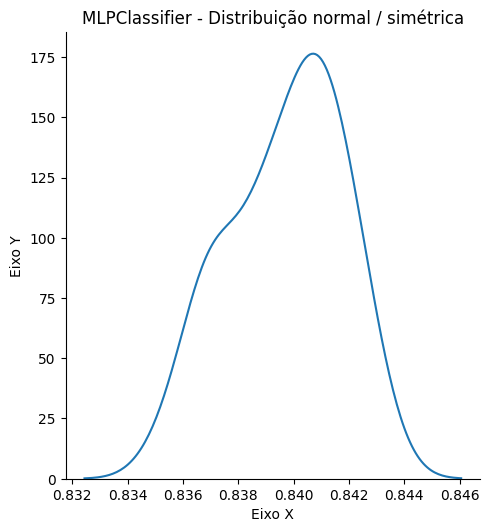

In [10]:
from scipy.stats import shapiro  # O teste de shapiro tem como hipótese nula que os dados seguem distribuição normal
from seaborn import displot
import matplotlib.pyplot as plt

significancia = 0.05  # Ou seja, ao menos 6% das evidências devem ser consistentes com a hipótese nula

print('Verificação do tipo de distribuição dos dados\n')
for classificador in tupla_de_classificadores:  # Para cada classificador na tupla de classificadores
    
    # Verificando se os dados seguem uma distribuição normal
    stat, p = shapiro(resultados[classificador.__name__])
    
    # Criando o gráfico de linha/densidade
    displot(resultados[classificador.__name__], kind='kde')

    # Print do resultado
    if p <= significancia:
        plt.title(f'{classificador.__name__} - Distribuição não-normal / assimétrica')
    else:
        plt.title(f'{classificador.__name__} - Distribuição normal / simétrica')

    plt.xlabel('Eixo X')
    plt.ylabel('Eixo Y')

    plt.show()

    

### Teste ANOVA ou Teste F

Os gráficos assimétricos apresentam formatos muito semelhantes ao de uma distribuição normal. Portanto, é possível aplicar o teste F - que supõe que um conjunto de dados segue distribuição normal - para verificar se há diferença estatística entre os métodos de aprendizado.

In [11]:
from scipy.stats import f_oneway

_, valor_p = f_oneway(
    resultados['DecisionTreeClassifier'],
    resultados['RandomForestClassifier'],
    resultados['KNeighborsClassifier'],
    resultados['LogisticRegression'],
    resultados['SVC'],
    resultados['MLPClassifier']
)

if valor_p <= significancia:  # Significância igual a 0.05 (5%)
    print('Hipótese nula rejeitada - Existe diferença estatística. Verificar o melhor modelo.')
else:
    print('Hipótese alternativa rejeitada - Não há diferença estatística.')

Hipótese nula rejeitada - Existe diferença estatística. Verificar o melhor modelo.


### Teste Tukey

Se há diferença estatística, é necessário verificar qual o método mais eficiente.

O teste de tukey retorna uma tabela que exibe as diferenças entre cada grupo do conjunto de dados.

In [12]:
# Preparação dos dados

# Tuplas para armazenar os valores de cada registro
tupla_metodo = ()
tupla_resultados = ()

for classificador in tupla_de_classificadores:  # Para cada classificador na tupla de classificadores

    resultados_metodo = resultados[classificador.__name__]  # Pegando os resultados do classificador

    for index in range(len(resultados_metodo)):  # Iterando os valores do resultado
        tupla_metodo += classificador.__name__,  # Adicionando nome do classificador à tupla
        tupla_resultados += resultados_metodo[index],  # Adicionando elemento dos resultados que corresponde ao index

# Criando o DataFrame
df_reformulado = pd.DataFrame({'Valores': tupla_resultados, 'Metodo': tupla_metodo})

# Limpando a memória
del tupla_metodo
del tupla_resultados

# Exibindo df
df_reformulado

,Valores,Metodo
0,0.8115,DecisionTreeClassifier
1,0.8085,DecisionTreeClassifier
2,0.8225,DecisionTreeClassifier
3,0.8145,DecisionTreeClassifier
4,0.8240,DecisionTreeClassifier
...,...,...
175,0.8375,MLPClassifier
176,0.8410,MLPClassifier
177,0.8410,MLPClassifier
178,0.8390,MLPClassifier


#### Explicação da tabela

Os valores que podemos observar na tabela de comparação é o ***valor de p*** (coluna p-adj), o valor da coluna ***reject*** e o valor de ***FWER*** (Valor de Alpha).

Primeiro, temos que a hipótese nula é: os grupos no conjunto de dados não tem diferença estatística entre si.

- **Valor P**: É a probabilidade de se observar os dados obtidos se a hipótese nula for verdadeira. De forma simplificada, seria como um percentual que representa a confiabilidade da hipótese nula.

- **Valor de Alpha**: É o valor que determina o intervalo de confiança do teste de hipótese. As opções para este parâmetro geralmente variam entre 0.05 e 0.01, representando 5% e 1% de margem de erro, respectivamente. Neste caso, o valor de alpha é 0.05 (5%), o que indica que a confiabilidade do teste de hipótese é de 95%.

- **Reject**: A coluna reject diz se a hipótese nula pode ser rejeitada ou não. *True* indica que sim, *False* indica que não.

In [13]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df_reformulado['Valores'], df_reformulado['Metodo'])
teste_estatistico = mc.tukeyhsd()
print(teste_estatistico)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
DecisionTreeClassifier   KNeighborsClassifier   0.0101    0.0  0.0077  0.0125   True
DecisionTreeClassifier     LogisticRegression   0.0251    0.0  0.0226  0.0275   True
DecisionTreeClassifier          MLPClassifier   0.0246    0.0  0.0221   0.027   True
DecisionTreeClassifier RandomForestClassifier    0.031    0.0  0.0286  0.0335   True
DecisionTreeClassifier                    SVC   0.0206    0.0  0.0181   0.023   True
  KNeighborsClassifier     LogisticRegression    0.015    0.0  0.0125  0.0174   True
  KNeighborsClassifier          MLPClassifier   0.0145    0.0   0.012  0.0169   True
  KNeighborsClassifier RandomForestClassifier   0.0209    0.0  0.0185  0.0234   True
  KNeighborsClassifier                    SVC   0.0105    0.0   0

In [14]:
df.mean().sort_values(ascending = False) * 100

RandomForestClassifier    84.616667
LogisticRegression        84.020000
MLPClassifier             83.970000
SVC                       83.571667
KNeighborsClassifier      82.523333
DecisionTreeClassifier    81.513333
dtype: float64

### Conclusão

Analisando os resultados, é possível afirmar que o método de aprendizado ***floresta randômica*** é estatisticamente superior em relação aos outros métodos testados no experimento para esta base de dados.

O conjunto dos melhores classificadores é composto por:

1. Floresta Randômica
2. Regressão Logística ou Rede Neural Multicamada (empate, não há diferença entre esses dois métodos para essa base de dados)
3. SVM


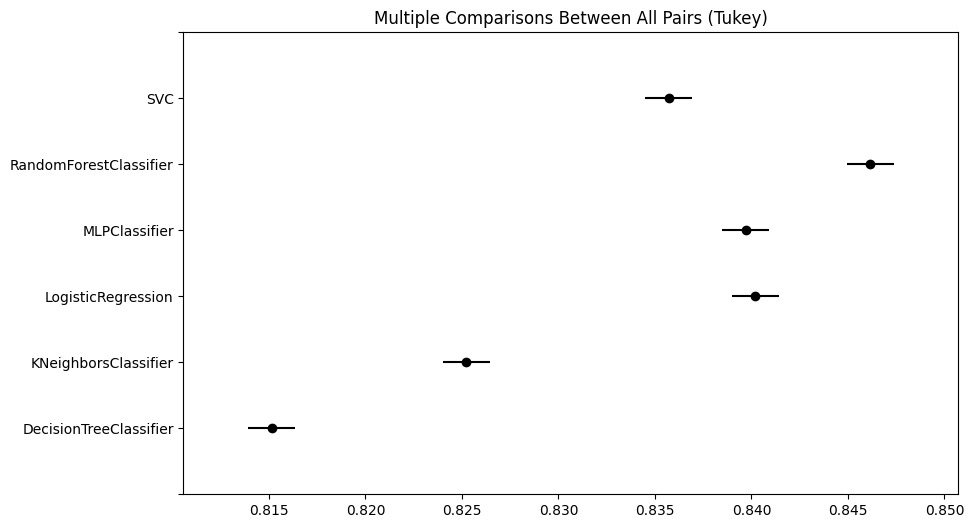

In [15]:
teste_estatistico.plot_simultaneous();